In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os


In [3]:
# !unzip "89YqJ24JdsIv"

In [9]:
## New Dataset
!wget "http://bashupload.com/8go2L/final.zip"

--2024-05-08 08:35:26--  http://bashupload.com/8go2L/final.zip
Resolving bashupload.com (bashupload.com)... 116.203.186.178
Connecting to bashupload.com (bashupload.com)|116.203.186.178|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31760118 (30M) [application/zip]
Saving to: ‘final.zip’

final.zip           100%[===================>]  30.29M  14.0MB/s    in 2.2s    

2024-05-08 08:35:29 (14.0 MB/s) - ‘final.zip’ saved [31760118/31760118]



In [10]:
!unzip "final.zip"

Archive:  final.zip
   creating: new_train/
   creating: new_train/Leprosy/
  inflating: new_train/Leprosy/Leprosy_0.jpg  
  inflating: new_train/Leprosy/Leprosy_0_jpg.rf.2436707b06e5bcba9843fb439b63455e.jpg  
  inflating: new_train/Leprosy/Leprosy_0_jpg.rf.875896d7b91bfa469bb59b1d2ca91cfb.jpg  
  inflating: new_train/Leprosy/Leprosy_0_jpg.rf.a9ce482a310c01b639479b3bf3ab288e.jpg  
  inflating: new_train/Leprosy/Leprosy_1.jpg  
  inflating: new_train/Leprosy/Leprosy_10.jpg  
  inflating: new_train/Leprosy/Leprosy_100.jpg  
  inflating: new_train/Leprosy/Leprosy_100_jpg.rf.b242cf9aca9cca86f365b8b343751f94.jpg  
  inflating: new_train/Leprosy/Leprosy_100_jpg.rf.d0932d19d939a45e5f22ddf539136bdc.jpg  
  inflating: new_train/Leprosy/Leprosy_100_jpg.rf.d99cd35605d77f65390a5817d0bfc58b.jpg  
  inflating: new_train/Leprosy/Leprosy_101.jpg  
  inflating: new_train/Leprosy/Leprosy_101_jpg.rf.04e4a278d98a5d1426f76255b143551e.jpg  
  inflating: new_train/Leprosy/Leprosy_101_jpg.rf.357ebdad2acce57df

In [2]:
import glob
import random as rd
possible_paths = [_ for _ in glob.glob("new_train/Leprosy/*")]
possible_paths2 =  [_ for _ in glob.glob("new_train/non_leprosy/*")]


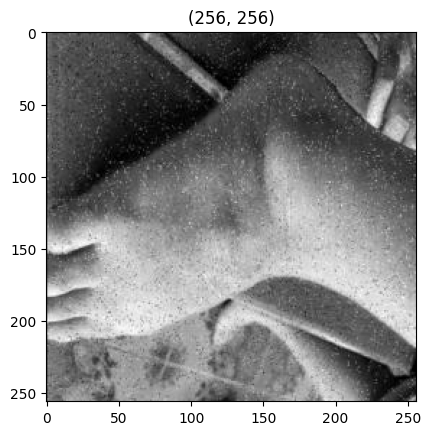

In [3]:
def random_plot(target_path):
  choice = rd.randint(0, possible_paths.__len__() - 1)
  data = np.asarray(Image.open(target_path[choice]))
  data = data/data.max()
  data = data[:,:, 0]
  plt.imshow(data, cmap='gray')
  plt.title(data.shape)

random_plot(possible_paths)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [5]:
import tensorflow_hub as hub

In [7]:
efficientnet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

In [8]:
import os
import glob
import numpy as np
from PIL import Image

data = []
label = []

def prep_data(target_dir):
    for indx, filename in enumerate(os.listdir(target_dir)):
        file_fullpath = target_dir + "/" + filename
        data.append(np.asarray(Image.open(file_fullpath)))
        if (target_dir.split("/")[-1]) == "Leprosy":
            label.append(1)
        else:
            label.append(0)

prep_data("new_train/Leprosy")
print("Non_Leprosy")
prep_data("new_train/Non_Leprosy")

Non_Leprosy


In [9]:
def random_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    saturation_factor = np.random.uniform(0.5, 1.0)
    hsv[:,:,1] = np.clip(hsv[:,:,1] * saturation_factor, 0, 255)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img

In [10]:
train_dir = "new_train/"
test_dir = "new_test/"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

gen1 = ImageDataGenerator(rescale=1/255.,
                          zoom_range=0.3,
                          rotation_range=0.3,
                          shear_range=0.2,
                          brightness_range=[0.5, 1.5],
                          preprocessing_function=random_saturation,
                          validation_split=0.2)

gen2 = ImageDataGenerator(rescale=1/255.)

train_data = gen1.flow_from_directory(directory=train_dir,
                                              target_size=(128,128),
                                              color_mode='rgb',
                                              shuffle=True,
                                              batch_size = 32,
                                              seed=42,
                                              class_mode = 'binary')

test_data = gen2.flow_from_directory(directory=test_dir,
                                             target_size=(128,128),
                                             color_mode='rgb',
                                             shuffle=False,
                                              batch_size = 32,
                                             seed=42,
                                             class_mode = 'binary')

Found 2500 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


In [14]:
model1 = Sequential([
    hub.KerasLayer(efficientnet_url,
    trainable=False,
    name ="feature_extractor_layer",
    input_shape=(128,128, 3)),
    GlobalAveragePooling2D(),
#     Dense(128, activation=tf.keras.activations.relu, name="dense_features"),
    Dense(1, activation=tf.keras.activations.linear, name="final_dense", kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.01))
])

model1.compile(
loss=tf.keras.losses.hinge,
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
metrics=['accuracy'])

history1=  model1.fit(
    train_data,
    epochs=30,
    batch_size=32,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[early_stopping]
)

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x000001E6EF370990> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

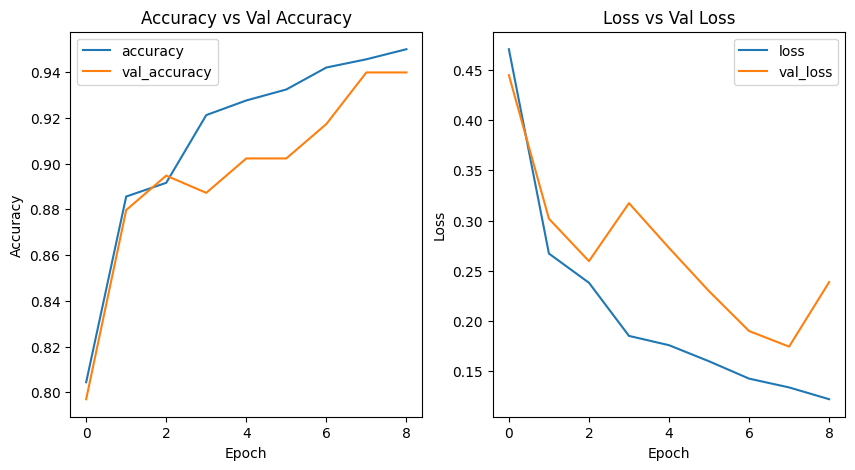

In [34]:
import matplotlib.pyplot as plt

def plot_the_graph(hist, epochs):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Accuracy vs Val Accuracy")
    plt.plot(hist.history['accuracy'][:epochs], label="accuracy")
    plt.plot(hist.history['val_accuracy'][:epochs], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Loss vs Val Loss')
    plt.plot(hist.history['loss'][:epochs], label="loss")
    plt.plot(hist.history['val_loss'][:epochs], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_the_graph(history1, 9)


In [35]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1280)              5919312   
 erasLayer)                                                      
                                                                 
 dense_features (Dense)      (None, 128)               163968    
                                                                 
 final_dense (Dense)         (None, 1)                 129       
                                                                 
Total params: 6083409 (23.21 MB)
Trainable params: 164097 (641.00 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [55]:

def predict_the_image(target_path="new_test/", model=model):
    tmp = os.listdir(target_path)
    img_type = rd.randint(0, 1)
    t = target_path + tmp[img_type] + "/"
    imgLists = glob.glob(t + "*")
    choice = rd.randint(0, len(imgLists) - 1)
    img = Image.open(imgLists[choice])
    img = img.resize((128, 128))
    img_data = np.asarray(img) / 255.0
    img_data = np.expand_dims(img_data, axis=0)
    out = model.predict(img_data)[0, 0]
    if out > 0:
        prediction = "Non Leprosy"
    else:
        prediction = "Leprosy"

    plt.imshow(img)
    plt.title(prediction)
    plt.axis('off')
    plt.show()

In [57]:
predict_the_image("new_test/", model)

1/1 [==============================] - 0s 69ms/step
2.7419302
1/1 [==============================] - 0s 93ms/step
2.336747
1/1 [==============================] - 0s 76ms/step
4.766338
1/1 [==============================] - 0s 72ms/step
2.6264641
1/1 [==============================] - 0s 72ms/step
4.455526
1/1 [==============================] - 0s 85ms/step
5.1752505
1/1 [==============================] - 0s 73ms/step
2.170658
1/1 [==============================] - 0s 68ms/step
2.7419302
1/1 [==============================] - 0s 63ms/step
4.696238
1/1 [==============================] - 0s 78ms/step
2.336747
